# Model Training
---
In this file, I will train the model using the prepared dataset using scikit-learn.

In [1]:
from Utils import setup_database_connection, true, false
from Utils import load_all_players
from Utils import evaluate_model
from imblearn.combine import SMOTEENN

engine = setup_database_connection()
player_data = load_all_players(engine)
banned_player_data = player_data[player_data['has_ban'] == true]
non_banned_player_data = player_data[player_data['has_ban'] == false]

Connecting to database...
Connection successful!
Loaded 226769 players


## Data Cleaning
---
Apply data cleaning to prepare the dataset for training:
1. Remove features with >50% zero values in banned player data
2. Remove players with >2 zero values across features

In [2]:
features_to_exclude = []
for feature in banned_player_data.select_dtypes(include=['int64', 'float64']).columns:
    banned_zeros = (banned_player_data[feature] == 0).sum()
    banned_zero_pct = (banned_zeros / len(banned_player_data)) * 100

    if banned_zero_pct > 50:
        features_to_exclude.append(feature)

thresholded_player_data = player_data.drop(columns=features_to_exclude)

ZERO_THRESHOLD = 2

numeric_features = thresholded_player_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
zero_counts_per_player = (thresholded_player_data[numeric_features] == 0).sum(axis=1)

mask = zero_counts_per_player <= ZERO_THRESHOLD

filtered_player_data = thresholded_player_data[mask].copy()

original_banned_count = (thresholded_player_data['has_ban'] == true).sum()
original_non_banned_count = (thresholded_player_data['has_ban'] == false).sum()
filtered_banned_count = (filtered_player_data['has_ban'] == true).sum()
filtered_non_banned_count = (filtered_player_data['has_ban'] == false).sum()

total_original = len(thresholded_player_data)
total_filtered = len(filtered_player_data)
total_removed = total_original - total_filtered
banned_removed = original_banned_count - filtered_banned_count
non_banned_removed = original_non_banned_count - filtered_non_banned_count

print(f"{'Category':<20} {'Original':<15} {'Filtered':<15} {'Removed':<15} {'% Retained':<15}")
print("-" * 80)
print(f"{'Banned Players':<20} {original_banned_count:<15,} {filtered_banned_count:<15,} {banned_removed:<15,} {(filtered_banned_count/original_banned_count*100):.2f}%")
print(f"{'Non-Banned Players':<20} {original_non_banned_count:<15,} {filtered_non_banned_count:<15,} {non_banned_removed:<15,} {(filtered_non_banned_count/original_non_banned_count*100):.2f}%")
print(f"{'Total Players':<20} {total_original:<15,} {total_filtered:<15,} {total_removed:<15,} {(total_filtered/total_original*100):.2f}%")

print(f"\nClass Balance:")
print("-" * 50)
print(f"Original - Banned: {(original_banned_count/total_original*100):.2f}% | Non-Banned: {(original_non_banned_count/total_original*100):.2f}%")
print(f"Filtered - Banned: {(filtered_banned_count/total_filtered*100):.2f}% | Non-Banned: {(filtered_non_banned_count/total_filtered*100):.2f}%")

print(f"\nData cleaning complete. Ready for training with {len(filtered_player_data):,} players and {filtered_player_data.shape[1]} features")

Category             Original        Filtered        Removed         % Retained     
--------------------------------------------------------------------------------
Banned Players       44,000          22,264          21,736          50.60%
Non-Banned Players   182,769         180,710         2,059           98.87%
Total Players        226,769         202,974         23,795          89.51%

Class Balance:
--------------------------------------------------
Original - Banned: 19.40% | Non-Banned: 80.60%
Filtered - Banned: 10.97% | Non-Banned: 89.03%

Data cleaning complete. Ready for training with 202,974 players and 29 features


# Training/Test Splitting
---

In [7]:
from sklearn.model_selection import train_test_split

columns_to_exclude = ['steam_id', 'created_at', 'name', 'total_matches', 'updated_at', 'has_ban']
X = filtered_player_data.drop(columns=columns_to_exclude)
y = filtered_player_data['has_ban'].map({true: 1, false: 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,
    stratify=y
)

print(f"Total dataset: {X.shape[0]:,} samples")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(f"  Banned: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"  Non-banned: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"\nTest class distribution:")
print(f"  Banned: {(y_test == 1).sum():,} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")
print(f"  Non-banned: {(y_test == 0).sum():,} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")


Total dataset: 202,974 samples
Training set: 162,379 samples
Test set: 40,595 samples

Training class distribution:
  Banned: 17,811 (10.97%)
  Non-banned: 144,568 (89.03%)

Test class distribution:
  Banned: 4,453 (10.97%)
  Non-banned: 36,142 (89.03%)


# Handling Class Imbalance
---
I will be using both undersampling and oversampling techniques to handle class imbalance in the dataset. I have too little banned players in my dataset in comparison to non banned players. I will be using scikit learns SMOTEENN method to oversample the banned players and undersample the non banned players.

In [4]:
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")

print(f"\nOriginal distribution:")
print(f"  Banned: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"  Non-banned: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")

print(f"\nResampled distribution:")
print(f"  Banned: {(y_train_resampled == 1).sum():,} ({(y_train_resampled == 1).sum()/len(y_train_resampled)*100:.2f}%)")
print(f"  Non-banned: {(y_train_resampled == 0).sum():,} ({(y_train_resampled == 0).sum()/len(y_train_resampled)*100:.2f}%)")

Original training set shape: (162379, 23)
Resampled training set shape: (260593, 23)

Original distribution:
  Banned: 17,811 (10.97%)
  Non-banned: 144,568 (89.03%)

Resampled distribution:
  Banned: 143,699 (55.14%)
  Non-banned: 116,894 (44.86%)


# Data Resampling Results
---
I went from 22000 banned players up to 167,000 and undersampled non banned players from 168,744 to 136,021, giving me a much more balanced dataset to train on. approx 55/45 split.

# Performance Metrics
---
Before I start training the model and choosing an algorithm, I will decide on what metrics I want to prioritise. Given we are trying to identify cheaters and crucially without incorrectly flagging legit players as cheaters I want to reduce the number of false positives, therefore prioritising Precision as my main metric. I would rather miss some cheaters (false negatives) than incorrectly flag legit players (false positives). I will also monitor Recall, but it will be a secondary metric to Precision. Preferably a good balance would be optimal.

# Algorithm Selection
---
I will start with Random Forest, however if I am not happy with the performance, I may try others such as XGBoost.

# Model Training
---

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_resampled, y_train_resampled)

,n_estimators,100
,criterion,'gini'
,max_depth,100
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Model Evaluation
---
Testing the trained model on the held-out test set to evaluate performance.

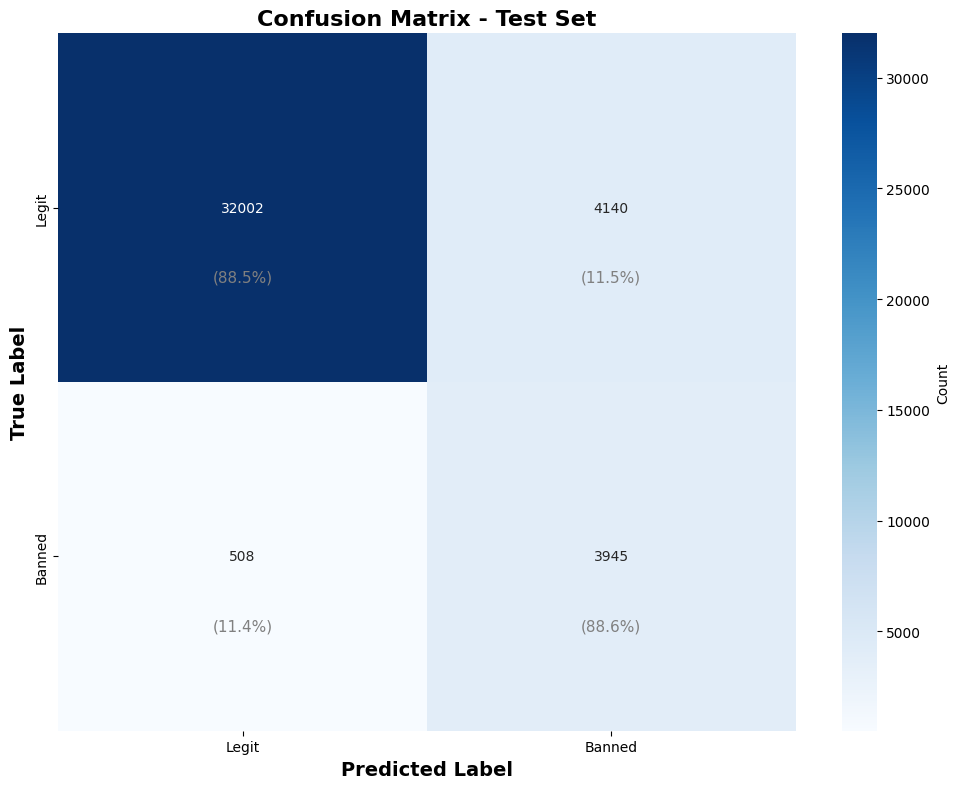

Metrics 

  ROC-AUC Score:           0.9499
  Precision (Banned):      0.4879
  Recall (Banned):         0.8859
  F1-Score (Banned):       0.6293
  False Positive Rate:     0.1145 (4,140 legit players incorrectly flagged)
  False Negative Rate:     0.1141 (508 cheaters missed)
  True Positives:          3,945 cheaters correctly identified
  True Negatives:          32,002 legit players correctly identified


In [6]:
# Evaluate model using reusable utility function
metrics = evaluate_model(clf, X_test, y_test, show_plot=True)

# Model Analysis
---
The initial run of the model was not perfect but definitely show promising results. Perhaps the biggest issue currently is that too many legit players are being incorrectly flagged as cheaters (false positives). The amount of cheaters being missed is acceptable. I will either try altering hyper-parameters, using a different algorithm or doing more/different approaches to my data preparation.